This notebook provides an example of retraining from the mipoint model to measure how much information is stored there after the interpolation.

In [1]:
import sys
sys.path.append("..")

In [10]:
import torch
from source.utils.utils import load_model
from source.utils.data_funcs import load_data
from source.utils.weight_matching import weight_matching
from source.utils.activation_matching import activation_matching
from source.utils.connect import interpolate_state_dicts
from source.utils.logger import Logger
from torch.utils.data import DataLoader
from source.utils.train import validate
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
class config:
    model = 'cifar_vgg16'
    dataset = 'cifar10'
    special_init = 'vgg_init' # 'vgg_init' (kaiming init) or None (uniform init)
    print_freq = 100
    data_dir = '../../Linear_Mode_Connectivity/data'
    n = 3 # number of interpolation points

In [4]:
# necessary to create logger if using the train/validate/eval_line etc. functions
Logger.setup_logging()
logger = Logger()

trainset, testset = load_data(config.data_dir, config.dataset)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

trainset_noaug, _ = load_data(config.data_dir, config.dataset, no_random_aug=True)
trainloader_noaug = DataLoader(trainset_noaug, batch_size=128, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
model_1, model_2 = load_model(config).to(device), load_model(config).to(device)

sd_1 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_20/model_1_160.pt', map_location=device)
sd_2 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_20/model_2_160.pt', map_location=device)

model_1.load_state_dict(sd_1)
model_2.load_state_dict(sd_2)

<All keys matched successfully>

Matching

In [ ]:
sd_2_wm, _ = weight_matching(config.model, sd_1, sd_2, device=device)
sd_2_am, _ = activation_matching(config.model, model_1, model_2, trainloader_noaug, 100, device) # no obvious difference found between trainloader and trainloader_noaug

In [7]:
sd_mid = interpolate_state_dicts(sd_1, sd_2, 0.5)
sd_wm_mid = interpolate_state_dicts(sd_1, sd_2_wm, 0.5)
sd_am_mid = interpolate_state_dicts(sd_1, sd_2_am, 0.5)
model_mid = load_model(config).to(device)
model_wm_mid = load_model(config).to(device)
model_am_mid = load_model(config).to(device)
model_mid.load_state_dict(sd_mid)
model_wm_mid.load_state_dict(sd_wm_mid)
model_am_mid.load_state_dict(sd_am_mid)

<All keys matched successfully>

Retraining the midpoint model

In [11]:
acc_threshold = 90

model_wm_mid_ft = deepcopy(model_wm_mid)
model_am_mid_ft = deepcopy(model_am_mid)

optimizer_wm_ft = torch.optim.SGD(model_wm_mid_ft.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer_am_ft = torch.optim.SGD(model_am_mid_ft.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
acc_train = [[], []]
acc_test = [[], []]
loss_train = [[], []]
loss_test = [[], []]
x_axis = []

for i, model in enumerate([model_wm_mid, model_am_mid]):
    loss, acc, _, _ = validate(trainloader_noaug, model, criterion, device, config)
    acc_train[i].append(acc)
    loss_train[i].append(loss)
    loss, acc, _, _ = validate(testloader, model, criterion, device, config)
    acc_test[i].append(acc)
    loss_test[i].append(loss)
x_axis.append(0)

for epoch in range(10):
    for iter, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        for model, optimizer in zip([model_wm_mid_ft, model_am_mid_ft], [optimizer_wm_ft, optimizer_am_ft]):
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # iter mode
        if (iter+1) % 10 == 0 or (iter+1)==len(trainloader):
            for i, model in enumerate([model_wm_mid_ft, model_am_mid_ft]):
                loss, acc, _, _ = validate(trainloader_noaug, model, criterion, device, config)
                acc_train[i].append(acc)
                loss_train[i].append(loss)
                loss, acc, _, _ = validate(testloader, model, criterion, device, config)
                acc_test[i].append(acc)
                loss_test[i].append(loss)
            x_axis.append(iter+1)
            if acc_train[0][-1] >= 90 and acc_train[1][-1] >= 90:
                break

In [13]:
acc_train_ori = [[], []]
acc_test_ori = [[], []]
loss_train_ori = [[], []]
loss_test_ori = [[], []]
iter_ori = [[], []]

In [14]:
model_init_ft = load_model(config).to(device)
optimizer_init_ft = torch.optim.SGD(model_init_ft.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

model_mid_ft = deepcopy(model_mid)
optimizer_mid_ft = torch.optim.SGD(model_mid_ft.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
for i, model in enumerate([model_mid_ft, model_init_ft]):
    loss, acc, _, _ = validate(trainloader_noaug, model, criterion, device, config)
    acc_train_ori[i].append(acc)
    loss_train_ori[i].append(loss)
    loss, acc, _, _ = validate(testloader, model, criterion, device, config)
    acc_test_ori[i].append(acc)
    loss_test_ori[i].append(loss)
iter_ori[0].append(0)
iter_ori[1].append(0)

In [ ]:
for epoch in range(15):
    print(f'Epoch {epoch+1}')
    for iter, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        for model, optimizer in zip([model_mid_ft, model_init_ft], [optimizer_mid_ft, optimizer_init_ft]):
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (iter+1)==len(trainloader):
                for i, model in enumerate([model_mid_ft, model_init_ft]):
                    loss, acc, _, _ = validate(trainloader_noaug, model, criterion, device, config)
                    acc_train_ori[i].append(acc)
                    loss_train_ori[i].append(loss)
                    loss, acc, _, _ = validate(testloader, model, criterion, device, config)
                    acc_test_ori[i].append(acc)
                    loss_test_ori[i].append(loss)
                iter_ori[0].append(iter+1+391*(epoch+1))
                iter_ori[1].append(iter+1+391*(epoch+1))
        if acc_train_ori[0][-1] >= acc_threshold and acc_train_ori[1][-1] >= acc_threshold:
            break

In [17]:
i_s = []
for acc_record in [acc_train[0], acc_train[1], acc_train_ori[0], acc_train_ori[1]]:
    i = 0
    while i < len(acc_record)-1 and acc_record[i] < acc_threshold:
        i += 1
    i_s.append(i)

In [18]:
acc_train_plot = [acc_train[0][:i_s[0]+1], acc_train[1][:i_s[1]+1]]
acc_test_plot = [acc_test[0][:i_s[0]+1], acc_test[1][:i_s[1]+1]]
loss_train_plot = [loss_train[0][:i_s[0]+1], loss_train[1][:i_s[1]+1]]
loss_test_plot = [loss_test[0][:i_s[0]+1], loss_test[1][:i_s[1]+1]]

acc_train_ori_plot = [acc_train_ori[0][:i_s[2]+1], acc_train_ori[1][:i_s[3]+1]]
acc_test_ori_plot = [acc_test_ori[0][:i_s[2]+1], acc_test_ori[1][:i_s[3]+1]]
loss_train_ori_plot = [loss_train_ori[0][:i_s[2]+1], loss_train_ori[1][:i_s[3]+1]]
loss_test_ori_plot = [loss_test_ori[0][:i_s[2]+1], loss_test_ori[1][:i_s[3]+1]]

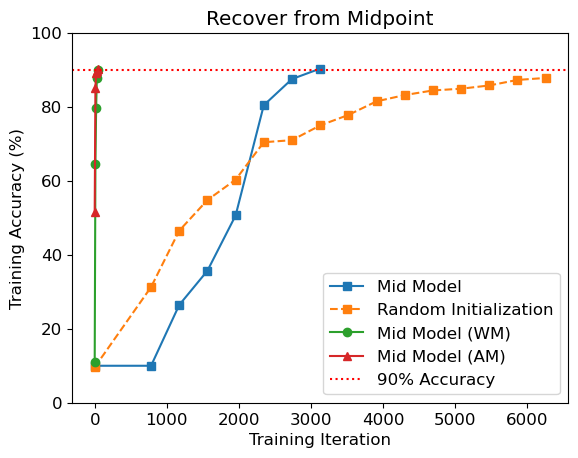

In [22]:
plt.rcParams.update({'font.size': 12})

plt.plot(iter_ori[0][:i_s[2]+1], acc_train_ori_plot[0], label='Mid Model', marker='s')
plt.plot(iter_ori[1][:i_s[3]+1], acc_train_ori_plot[1], label='Random Initialization', marker='s', linestyle='--')
plt.plot(x_axis[:i_s[0]+1], acc_train_plot[0], label='Mid Model (WM)', marker='o')
plt.plot(x_axis[:i_s[1]+1], acc_train_plot[1], label='Mid Model (AM)', marker='^')

plt.axhline(y=acc_threshold, color='r', linestyle=':', label=f'{acc_threshold}% Accuracy')
plt.ylabel('Training Accuracy (%)')
plt.ylim(0, 100)
# plt.xlim(0, 1000)
plt.xlabel('Training Iteration')
plt.title('Recover from Midpoint')
plt.legend()